In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import missingno as msno
import warnings
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [26]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def different_thrsholds(X, y, thresholds, model):
    y_pred_proba = model.predict_proba(X)  #predict_prob 获得一个概率值

    plt.figure(figsize=(30,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 

        plt.subplot(6,3,j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Plot non-normalized confusion matrix
        class_names = [0,1]
        plot_confusion_matrix(cnf_matrix
                              , classes=class_names)

        
def different_thrsholds_list(X, y, thresholds, model_list):
    model_num = len(model_list)
    y_pred_proba = [0, 0]
    for model in model_list:
        y_pred_proba += model.predict_proba(X)  #predict_prob 获得一个概率值
    y_pred_proba = y_pred_proba / model_num

    plt.figure(figsize=(30,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 

        plt.subplot(6,3,j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Plot non-normalized confusion matrix
        class_names = [0,1]
        plot_confusion_matrix(cnf_matrix
                              , classes=class_names)

### 采样算法

#### SMOTE

In [2]:
data = pd.read_csv('data/ads_train.csv') 
data.dtypes.value_counts()
new_col = ['isbuyer', 'visit_freq', 'buy_interval', 'sv_interval',
       'expected_time_buy', 'expected_time_visit', 'last_buy', 'last_visit',
       'multiple_buy', 'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy']
data = data[new_col]
col = data.select_dtypes(include=['int64','float64']).columns
col = col.drop('y_buy')
data_ml_df = data
sc = StandardScaler()
data_ml_df[col] = sc.fit_transform(data_ml_df[col])
data_ml_df.head()
x_feature = list(data_ml_df.columns)
x_feature.remove('y_buy')
x_val = data_ml_df[x_feature]
y_val = data_ml_df['y_buy']
X = data_ml_df[col]
y = data_ml_df['y_buy']
sm = SMOTE(random_state=42)
X_source, y_source = X, y
X_smote, y_smote = sm.fit_sample(X, y)
print('通过SMOTE方法平衡正负样本后')
n_sample = y_smote.shape[0]
n_pos_sample = y_smote[y_smote == 0].shape[0]
n_neg_sample = y_smote[y_smote == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))

通过SMOTE方法平衡正负样本后
样本个数：76074; 正样本占50.00%; 负样本占50.00%


#### cluster采样

In [5]:
cc = ClusterCentroids(random_state=0)
X_cluster, y_cluster = cc.fit_sample(X, y)
print(sorted(Counter(y_cluster).items()))

[(0, 172), (1, 172)]


#### rus采样

In [14]:
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

print(sorted(Counter(y_rus).items()))

[(0, 172), (1, 172)]


#### nml采样

In [17]:
nml = NearMiss(random_state=0, version=1)
X_nml, y_nml = nml.fit_sample(X, y)
print(sorted(Counter(y_nml).items()))

[(0, 172), (1, 172)]


#### EditedNearestNeighbours采样

In [43]:
enn = EditedNearestNeighbours(random_state=0)
X_enn, y_enn = enn.fit_sample(X, y)
print(sorted(Counter(y_enn).items()))

[(0, 37548), (1, 172)]


#### RepeatedEditedNearestNeighbours采样

In [44]:
renn = RepeatedEditedNearestNeighbours(random_state=0)
X_renn, y_renn = renn.fit_sample(X, y)
print(sorted(Counter(y_renn).items()))

[(0, 37344), (1, 172)]


#### ALLKNN采样

In [45]:
allknn = AllKNN(random_state=0)
X_allknn, y_allknn = allknn.fit_sample(X, y)
print(sorted(Counter(y_allknn).items()))

[(0, 37448), (1, 172)]


#### SMOTEENN采样

In [46]:
smote_enn = SMOTEENN(random_state=0)
X_smote_enn, y_smote_enn = smote_enn.fit_sample(X, y)

print(sorted(Counter(y_smote_enn).items()))

[(0, 34405), (1, 37032)]


#### CondensedNearestNeighbour采样

In [47]:
cnn = CondensedNearestNeighbour(random_state=0)
X_cnn, y_cnn = cnn.fit_sample(X, y)
print(sorted(Counter(y_cnn).items()))

[(0, 1068), (1, 172)]


### 逻辑回归

#### 使用cluster采样

Test set accuracy score: 0.50967
              precision    recall  f1-score   support

           0       0.51      1.00      0.67     19368
           1       0.81      0.01      0.01     18841

   micro avg       0.51      0.51      0.51     38209
   macro avg       0.66      0.50      0.34     38209
weighted avg       0.66      0.51      0.35     38209

Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9534883720930233
Recall metric in the testing dataset:  0.9302325581395349
Recall metric in the testing dataset:  0.9127906976744186
Recall metric in the testing dataset:  0.8662790697674418
Recall metric in the testing dataset:  0.8430232558139535
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8081395348837209
Recall metric in the testing dataset:  0.75
Recall metric in the testing dataset:  0.6918604651162791
Recall metric in

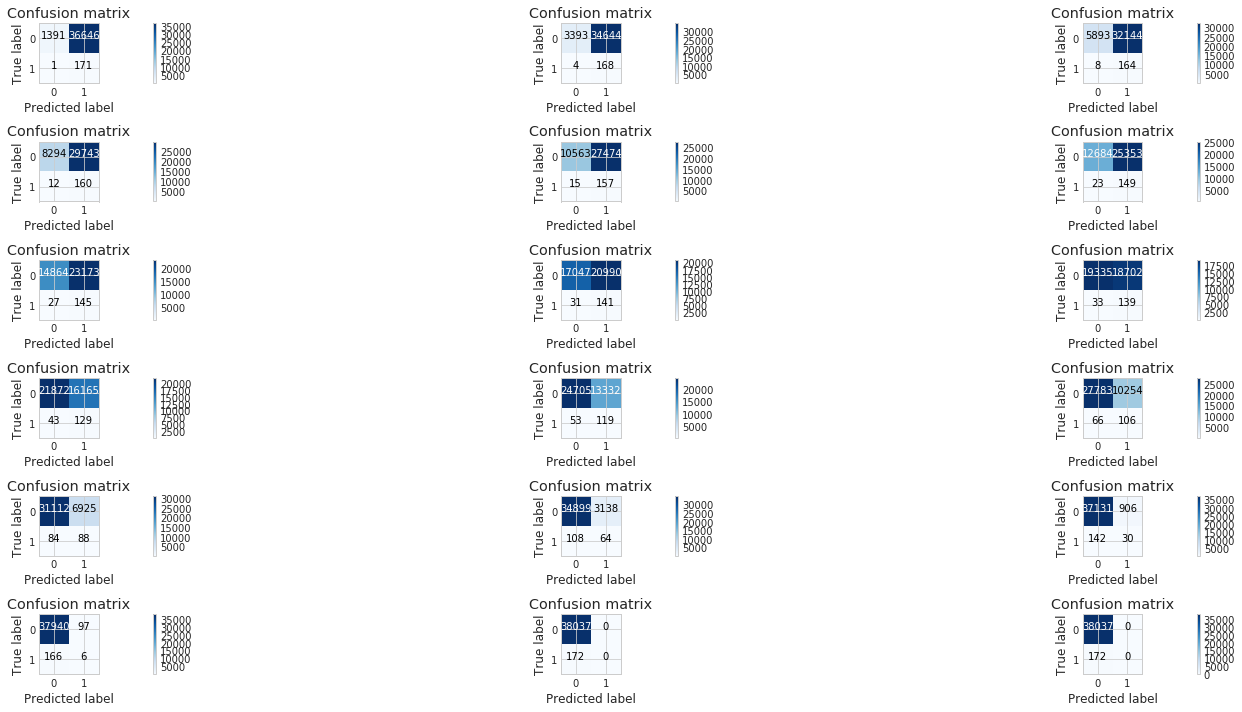

In [59]:
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

lg_grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = lg_grid_search.fit(X_cluster, y_cluster)
y_pred = lg_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=lg_grid_search)

#### 使用rus采样

Test set accuracy score: 0.66767
              precision    recall  f1-score   support

           0       0.67      1.00      0.80     25385
           1       0.87      0.01      0.02     12824

   micro avg       0.67      0.67      0.67     38209
   macro avg       0.77      0.51      0.41     38209
weighted avg       0.73      0.67      0.54     38209

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9709302325581395
Recall metric in the testing dataset:  0.9593023255813954
Recall metric in the testing dataset:  0.9302325581395349
Recall metric in the testing dataset:  0.9127906976744186
Recall metric in the testing dataset:  0.8662790697674418
Recall metric in the testing dataset:  0.6976744186046512
Recall metric in the testing dataset:  0.6337209302325582
Recall metric in the testing dataset:  0.476744

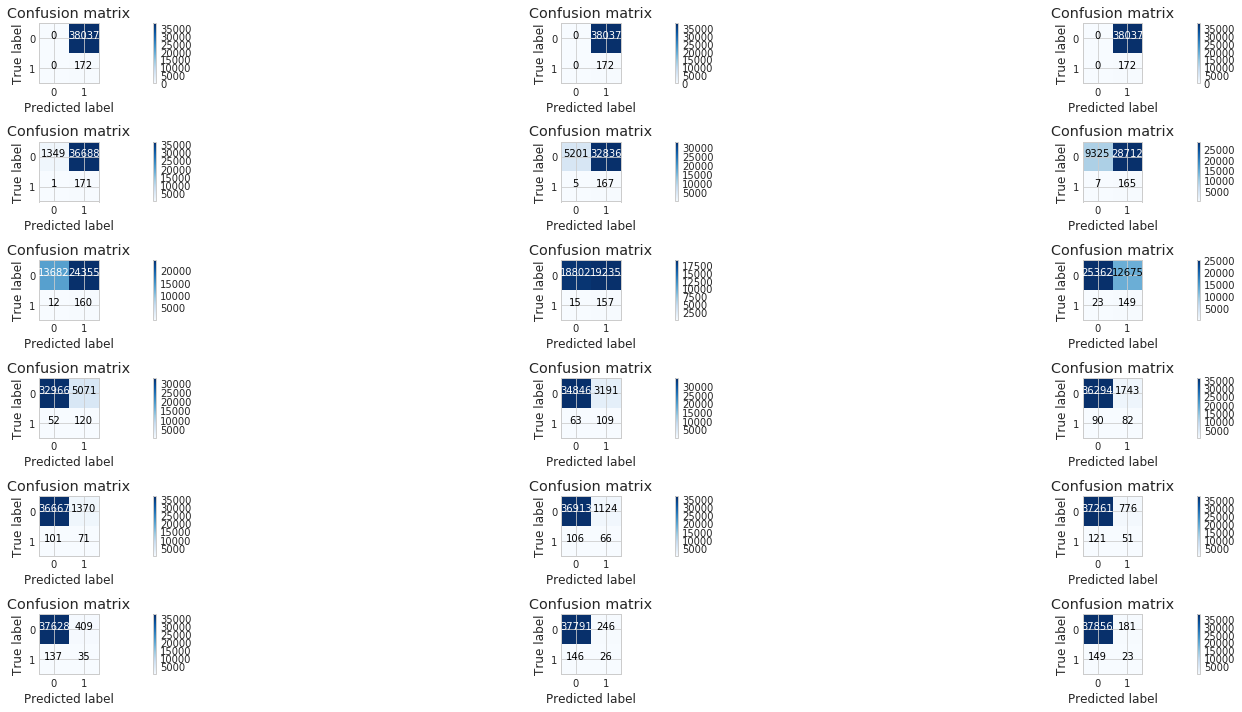

In [60]:
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

lg_grid_search_rus = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = lg_grid_search_rus.fit(X_rus, y_rus)
y_pred = lg_grid_search_rus.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=lg_grid_search_rus)

### 随机森林

#### 使用cluster采样

In [6]:
param_grid = {'n_estimators':[100],
             'criterion':['entropy'],
             'n_jobs':[-1],
             "warm_start":[True],
             "class_weight":[ 'balanced']}
random_grid_search = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search.fit(X_cluster, y_cluster)
y_pred = random_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))

Test set accuracy score: 0.49656
              precision    recall  f1-score   support

           0       0.49      1.00      0.66     18801
           1       1.00      0.01      0.02     19408

   micro avg       0.50      0.50      0.50     38209
   macro avg       0.75      0.50      0.34     38209
weighted avg       0.75      0.50      0.33     38209



Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing dataset:  0.9418604651162791
Recall metric in the testing dataset:  0.8313953488372093
Recall metric in the testing dataset:  0.7732558139534884
Recall metric in the testing dataset:  0.7209302325581395
Recall metric in the testing dataset:  0.622093023255814
Recall metric in the testing dataset:  0.5116279069767442


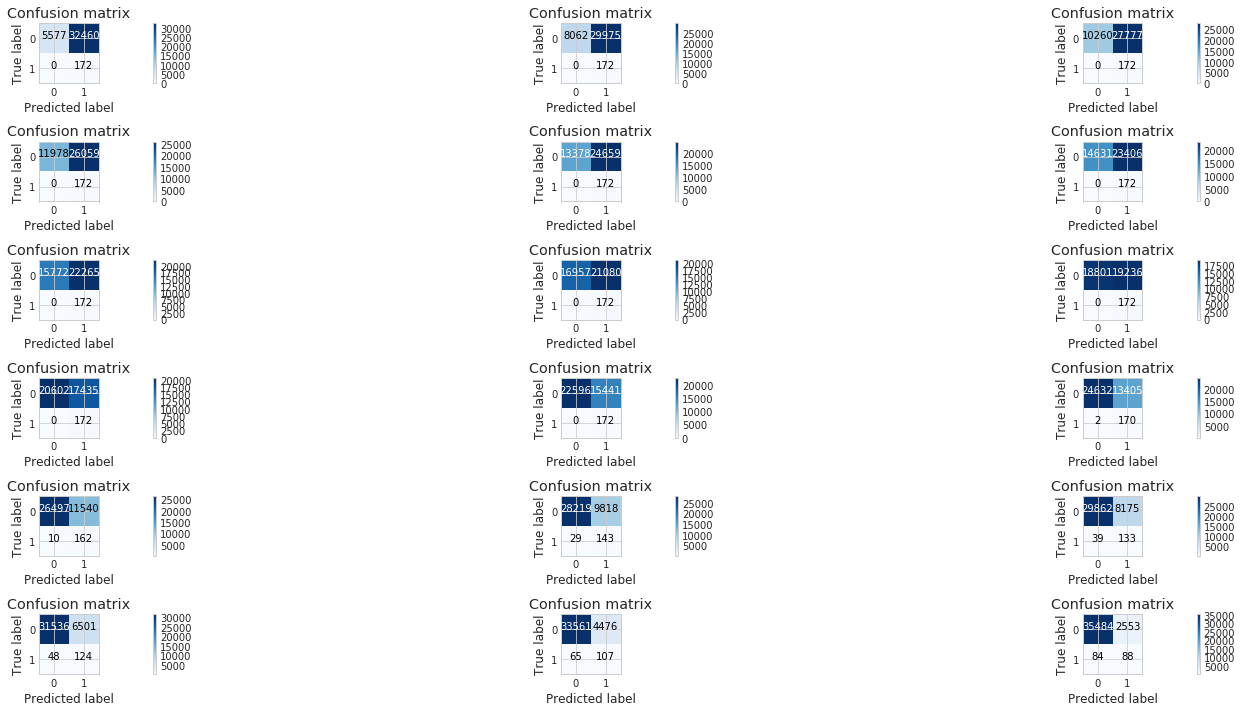

In [10]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=random_grid_search)

In [18]:
print("Best parameters: {}".format(random_grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(random_grid_search.best_score_))

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 100, 'n_jobs': -1, 'warm_start': True}
Best cross-validation score: 0.81977


#### 使用rus采样

In [19]:
param_grid = {'n_estimators':[1000],
             'criterion':['entropy'],
             'n_jobs':[-1],
             "warm_start":[True],
             "class_weight":[{0:1/38037, 1:1/172}]}
random_grid_search_rus = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search_rus.fit(X_rus, y_rus)
y_pred = random_grid_search_rus.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(random_grid_search_rus.best_params_))
print("Best cross-validation score: {:.5f}".format(random_grid_search_rus.best_score_))

Test set accuracy score: 0.81931
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     31133
           1       1.00      0.02      0.05      7076

   micro avg       0.82      0.82      0.82     38209
   macro avg       0.91      0.51      0.47     38209
weighted avg       0.85      0.82      0.74     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'entropy', 'n_estimators': 1000, 'n_jobs': -1, 'warm_start': True}
Best cross-validation score: 0.80814


Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9825581395348837
Recall metric in the testing dataset:  0.9011627906976745
Recall metric in the testing dataset:  0.8313953488372093
Recall metric in the testing dataset:  0.7790697674418605
Recall metric in the testing dataset:  0.75
Recall metric in the testing dataset:  0.5988372093023255
Recall metric in the testing dataset:  0.36627906976744184


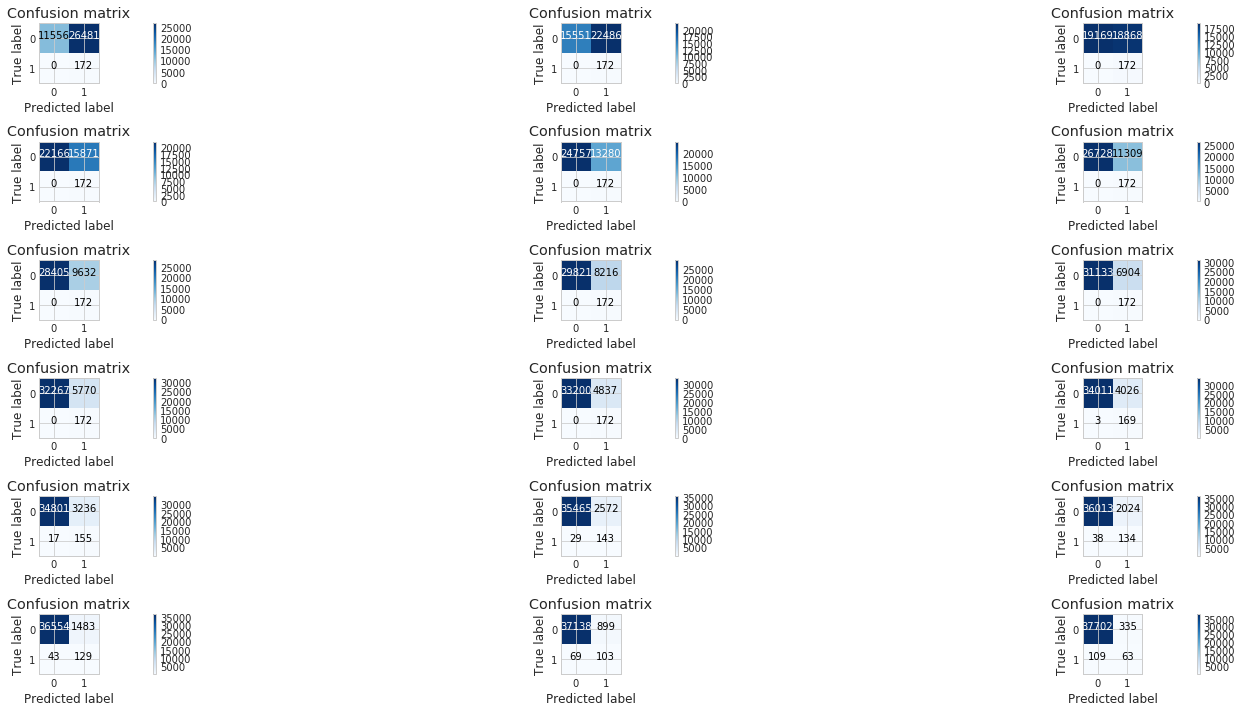

In [20]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=random_grid_search_rus)

#### 使用nml采样，效果很差

In [21]:
param_grid = {'n_estimators':[1000],
             'criterion':['entropy'],
             'n_jobs':[-1],
             "warm_start":[False],
             "class_weight":[{0:1/38037, 1:1/172}]}
random_grid_search_nml = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search_nml.fit(X_nml, y_nml)
y_pred = random_grid_search_nml.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(random_grid_search_nml.best_params_))
print("Best cross-validation score: {:.5f}".format(random_grid_search_nml.best_score_))

Test set accuracy score: 0.01696
              precision    recall  f1-score   support

           0       0.01      1.00      0.02       476
           1       1.00      0.00      0.01     37733

   micro avg       0.02      0.02      0.02     38209
   macro avg       0.51      0.50      0.02     38209
weighted avg       0.99      0.02      0.01     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'entropy', 'n_estimators': 1000, 'n_jobs': -1, 'warm_start': False}
Best cross-validation score: 0.95640


Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9825581395348837
Recall metric in the testing dataset:  0.9709302325581395
Recall metric in the testing dataset:  0.9476744186046512
Recall metric in the testing dataset:  0.9476744186046512
Recall metric in the testing dataset:  0.936046511627907
Recall metric in the testing dataset:  0.9069767441860465
Recall metric in the testing dataset:  0.8604651162790697


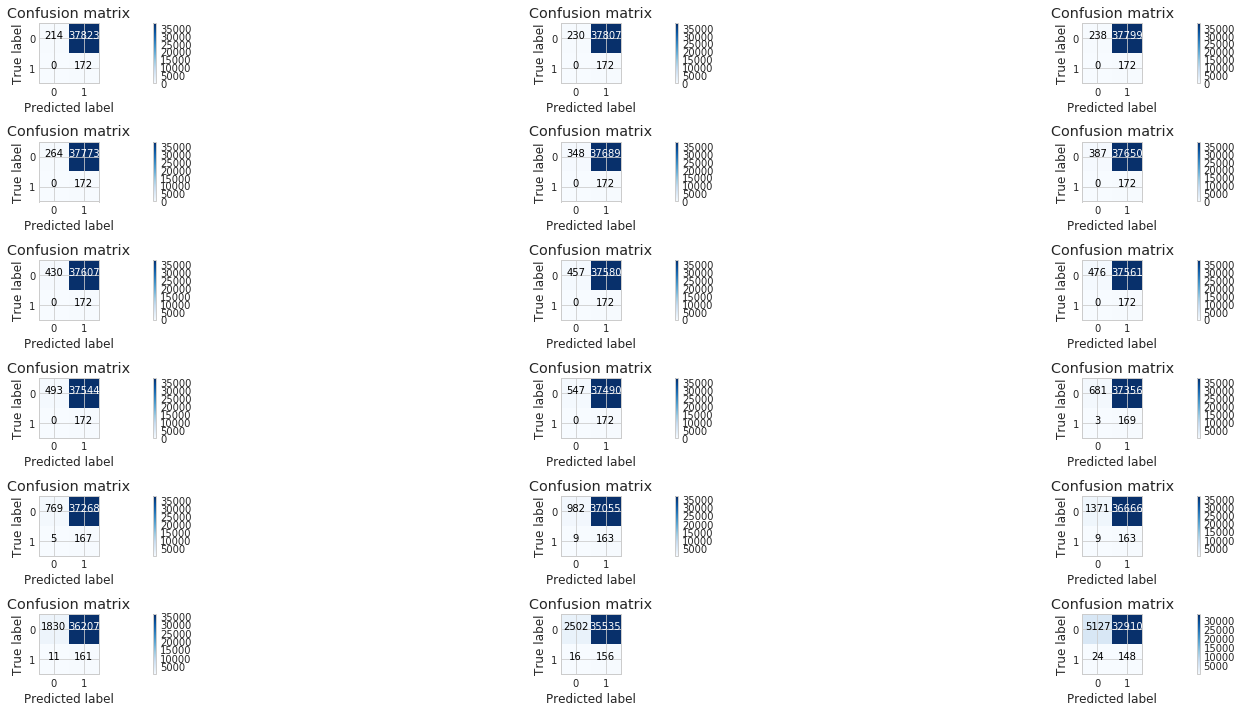

In [22]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=random_grid_search_nml)

#### 使用SMOTEENN采样

In [48]:
param_grid = {'n_estimators':[1000],
             'criterion':['entropy'],
             'n_jobs':[-1],
             "warm_start":[False],
             "class_weight":[{0:1/38037, 1:1/172}]}
random_grid_search_smote_enn = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search_smote_enn.fit(X_nml, y_nml)
y_pred = random_grid_search_smote_enn.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(random_grid_search_smote_enn.best_params_))
print("Best cross-validation score: {:.5f}".format(random_grid_search_smote_enn.best_score_))

Test set accuracy score: 0.01699
              precision    recall  f1-score   support

           0       0.01      1.00      0.02       477
           1       1.00      0.00      0.01     37732

   micro avg       0.02      0.02      0.02     38209
   macro avg       0.51      0.50      0.02     38209
weighted avg       0.99      0.02      0.01     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'entropy', 'n_estimators': 1000, 'n_jobs': -1, 'warm_start': False}
Best cross-validation score: 0.95349


Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9825581395348837
Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9476744186046512
Recall metric in the testing dataset:  0.9476744186046512
Recall metric in the testing dataset:  0.936046511627907
Recall metric in the testing dataset:  0.9127906976744186
Recall metric in the testing dataset:  0.8488372093023255


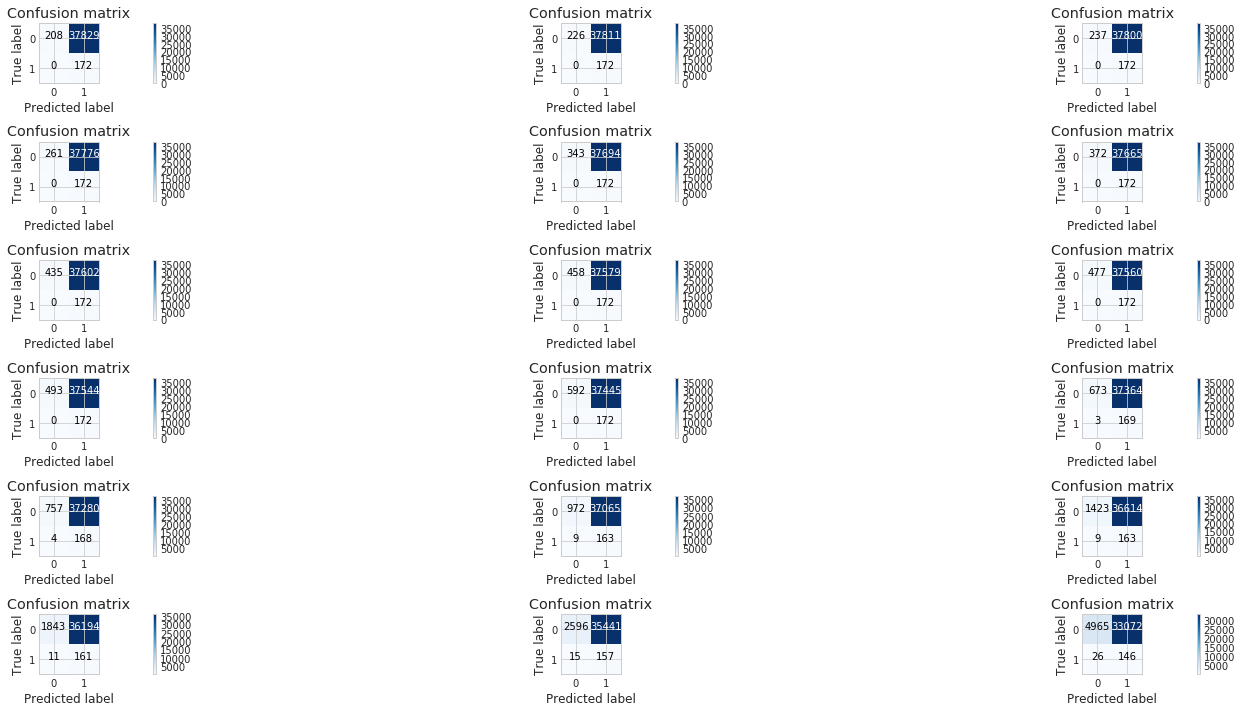

In [49]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=random_grid_search_smote_enn)

#### 使用CondensedNearestNeighbour采样

In [50]:
param_grid = {'n_estimators':[1000],
             'criterion':['entropy'],
             'n_jobs':[-1],
             "warm_start":[False],
             "class_weight":[{0:1/38037, 1:1/172}]}
random_grid_search_cnn = GridSearchCV(RandomForestClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = random_grid_search_cnn.fit(X_nml, y_nml)
y_pred = random_grid_search_cnn.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(random_grid_search_cnn.best_params_))
print("Best cross-validation score: {:.5f}".format(random_grid_search_cnn.best_score_))

Test set accuracy score: 0.01712
              precision    recall  f1-score   support

           0       0.01      1.00      0.03       482
           1       1.00      0.00      0.01     37727

   micro avg       0.02      0.02      0.02     38209
   macro avg       0.51      0.50      0.02     38209
weighted avg       0.99      0.02      0.01     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'entropy', 'n_estimators': 1000, 'n_jobs': -1, 'warm_start': False}
Best cross-validation score: 0.95349


Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9534883720930233
Recall metric in the testing dataset:  0.9476744186046512
Recall metric in the testing dataset:  0.936046511627907
Recall metric in the testing dataset:  0.9127906976744186
Recall metric in the testing dataset:  0.8604651162790697


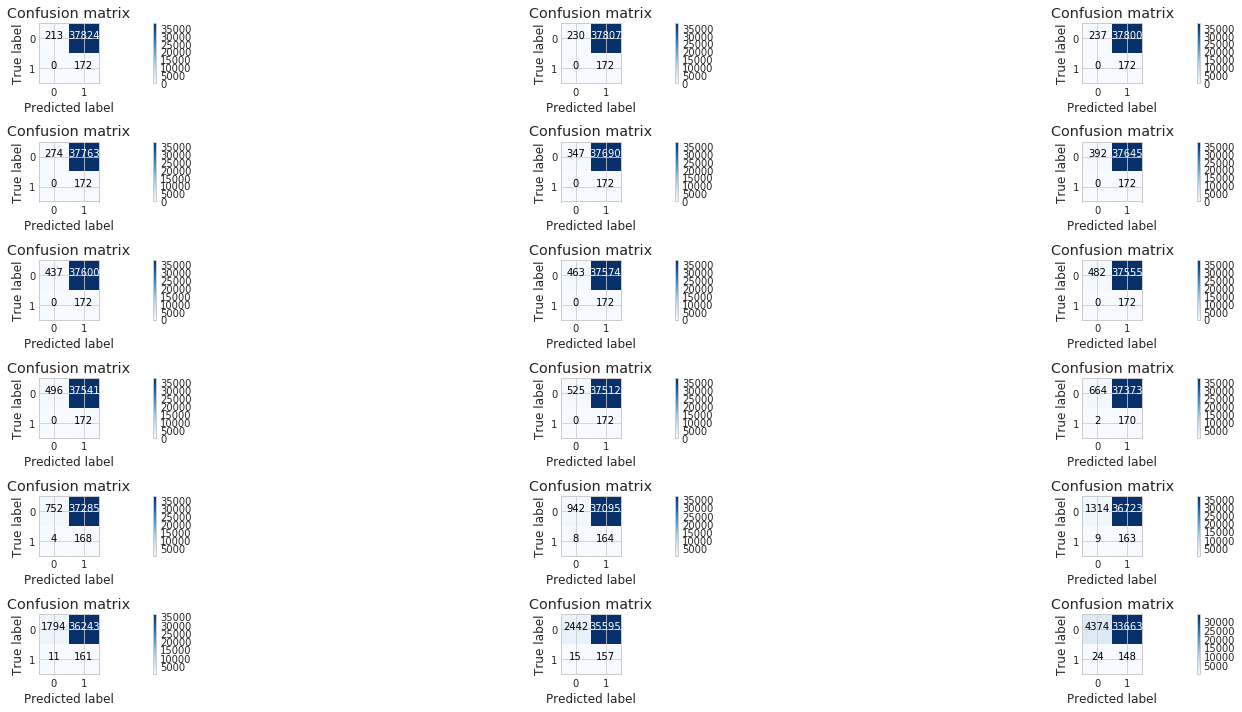

In [51]:
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=random_grid_search_cnn)

#### 同质模型集成

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9651162790697675
Recall metric in the testing dataset:  0.9069767441860465
Recall metric in the testing dataset:  0.8313953488372093
Recall metric in the testing dataset:  0.686046511627907
Recall metric in the testing dataset:  0.5755813953488372
Recall metric in the testing dataset:  0.3953488372093023


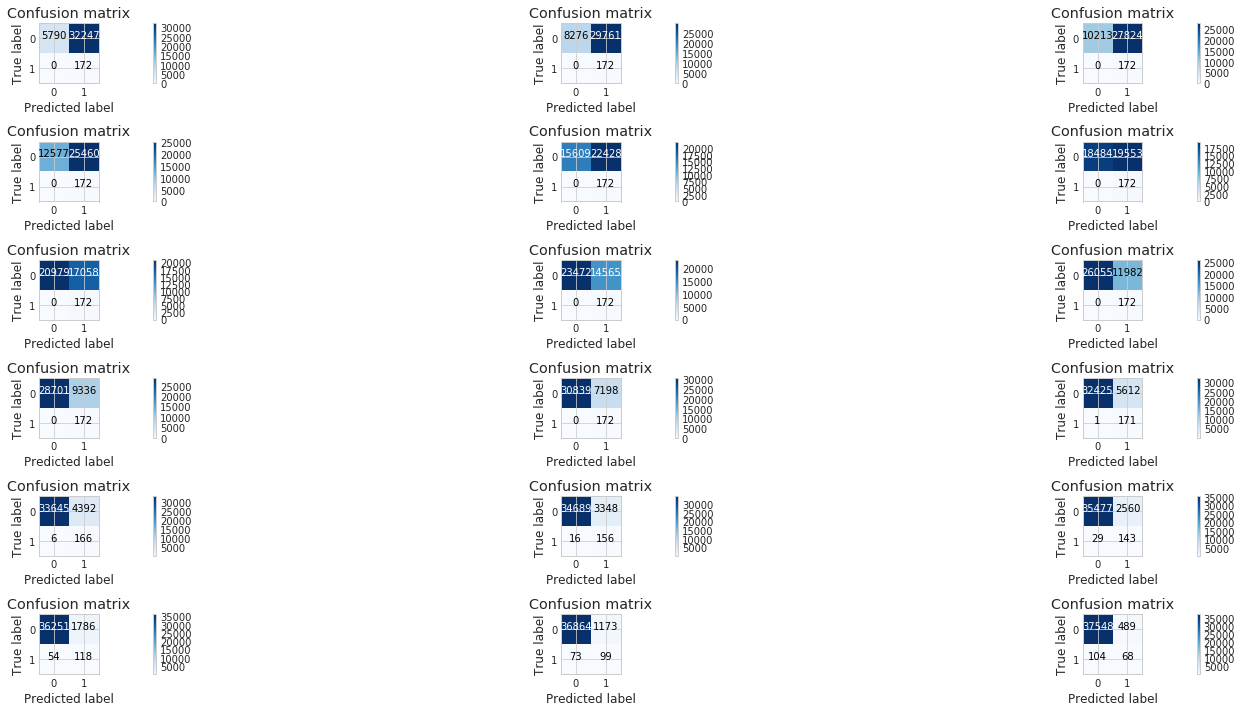

In [27]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, model_list=[random_grid_search, random_grid_search_rus])

### SGDClassifier

#### cluster采样效果很差

Test set accuracy score: 0.61234
              precision    recall  f1-score   support

           0       0.61      1.00      0.76     23287
           1       0.82      0.01      0.02     14922

   micro avg       0.61      0.61      0.61     38209
   macro avg       0.72      0.50      0.39     38209
weighted avg       0.69      0.61      0.47     38209

Recall metric in the testing dataset:  0.8255813953488372
Recall metric in the testing dataset:  0.8255813953488372
Recall metric in the testing dataset:  0.8255813953488372
Recall metric in the testing dataset:  0.8255813953488372
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Recall metric in the testing dataset:  0.8197674418604651
Re

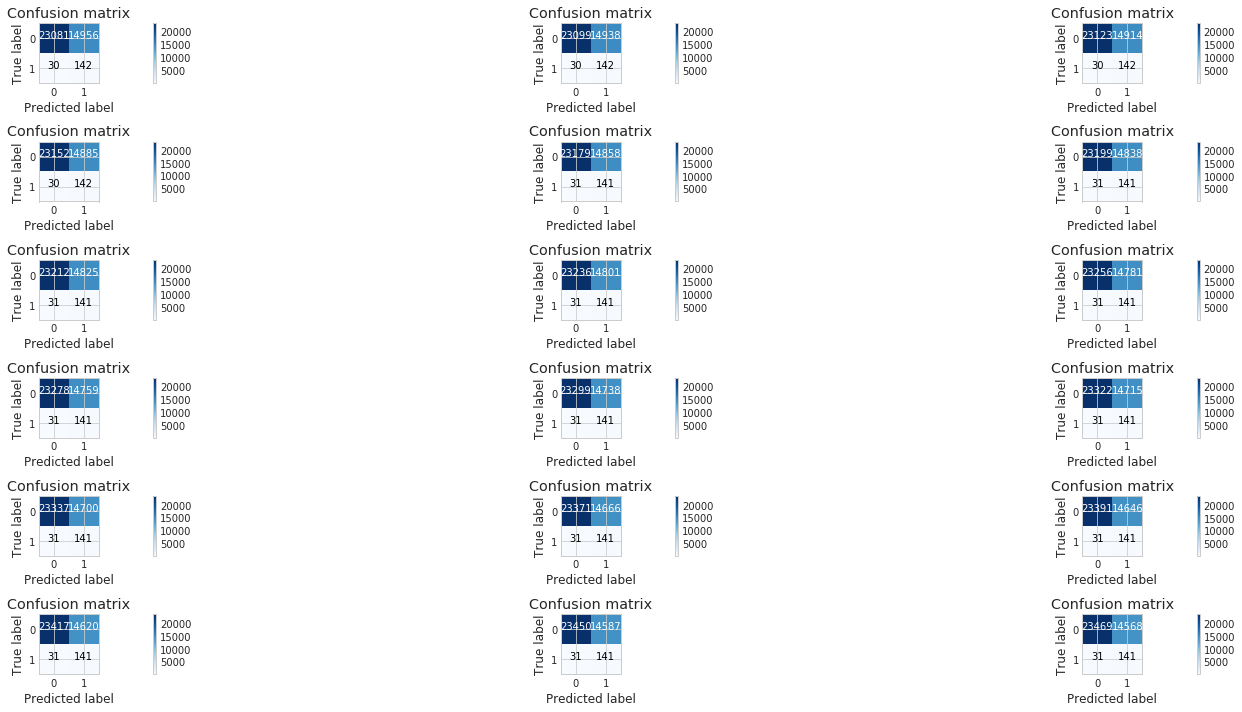

In [30]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber'],
              'penalty': ['l2', 'l1', 'elasticnet'],
             'max_iter':[5, 10, 20],
             'n_jobs':[-1]}
sgd_grid_search = GridSearchCV(SGDClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = sgd_grid_search.fit(X_cluster, y_cluster)
y_pred = sgd_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=sgd_grid_search)


In [ ]:
print("Best parameters: {}".format(sgd_grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(sgd_grid_search.best_score_))

#### rus采样

Test set accuracy score: 0.69115
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     26284
           1       0.86      0.01      0.02     11925

   micro avg       0.69      0.69      0.69     38209
   macro avg       0.78      0.51      0.42     38209
weighted avg       0.74      0.69      0.57     38209

Best parameters: {'loss': 'log', 'max_iter': 10, 'n_jobs': -1, 'penalty': 'elasticnet'}
Best cross-validation score: 0.75581
Recall metric in the testing dataset:  0.8837209302325582
Recall metric in the testing dataset:  0.877906976744186
Recall metric in the testing dataset:  0.877906976744186
Recall metric in the testing dataset:  0.877906976744186
Recall metric in the testing dataset:  0.877906976744186
Recall metric in the testing dataset:  0.877906976744186
Recall metric in the testing dataset:  0.8662790697674418
Recall metric in the testing dataset:  0.8662790697674418
Recall metric in the testing dataset:  0.860465116279069

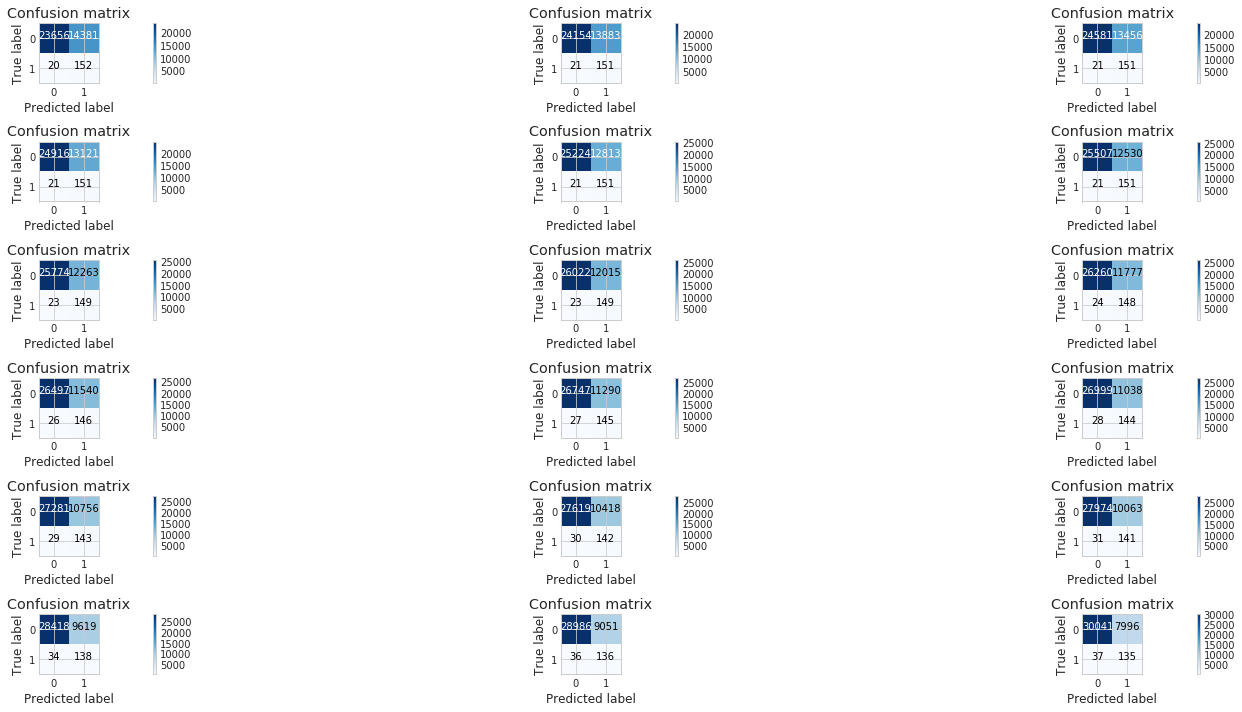

In [32]:
param_grid = {'loss': ['log', 'modified_huber'],
              'penalty': ['l2', 'l1', 'elasticnet'],
             'max_iter':[5, 10, 20],
             'n_jobs':[-1]}
sgd_grid_search_rus = GridSearchCV(SGDClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = sgd_grid_search_rus.fit(X_rus, y_rus)
y_pred = sgd_grid_search_rus.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(sgd_grid_search_rus.best_params_))
print("Best cross-validation score: {:.5f}".format(sgd_grid_search_rus.best_score_))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=sgd_grid_search_rus)

### GradientBoostingClassifier

#### 使用cluster采样

Test set accuracy score: 0.43322
              precision    recall  f1-score   support

           0       0.43      1.00      0.60     16395
           1       0.96      0.01      0.02     21814

   micro avg       0.43      0.43      0.43     38209
   macro avg       0.70      0.50      0.31     38209
weighted avg       0.73      0.43      0.27     38209

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing dataset:  0.9709302325581395
Recall metric in the testing dataset:  0.9593023255813954
Recall metric in the testing dataset:  0.9418604651162791
Recall metric in the testing dataset:  0.9244186046511628
Recall metric in the testing dataset:  0.9011627906976745
Reca

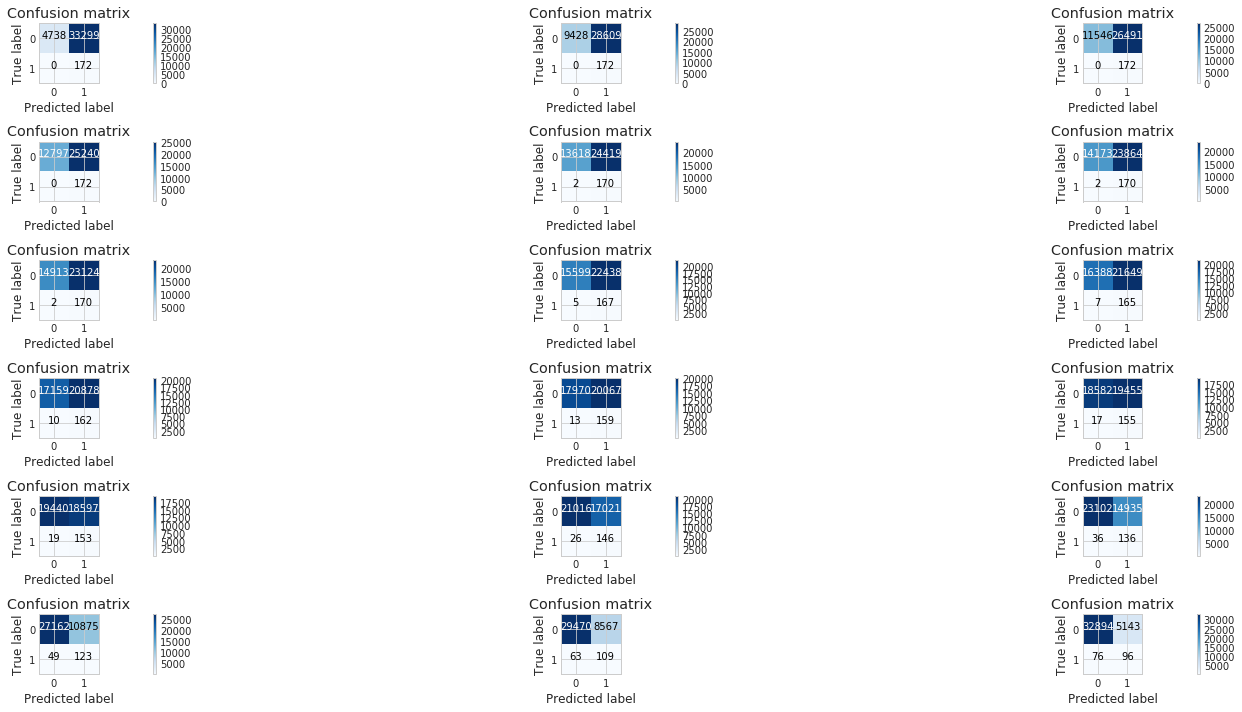

In [66]:
param_grid = {'loss': ["deviance", "exponential"],
              'learning_rate': [0.1, 0.01, 0.001],
             'criterion':["friedman_mse", "mse"],
             'warm_start':[False, True]}
gb_grid_search = GridSearchCV(GradientBoostingClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = gb_grid_search.fit(X_cluster, y_cluster)
y_pred = gb_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=gb_grid_search)

#### 使用rus采样

Test set accuracy score: 0.80840
Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'warm_start': False}
Best cross-validation score: 0.78779
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     30742
           1       0.92      0.02      0.04      7467

   micro avg       0.81      0.81      0.81     38209
   macro avg       0.87      0.51      0.47     38209
weighted avg       0.83      0.81      0.73     38209

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9825581395348837
Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9767441860465116
Recall metric in the testing dataset:  0.9593023255813954
Recall metric in the testing dataset:  0.936046511627907
Recall metric in the testing dataset:  0.9244186046511628
Recall metric in 

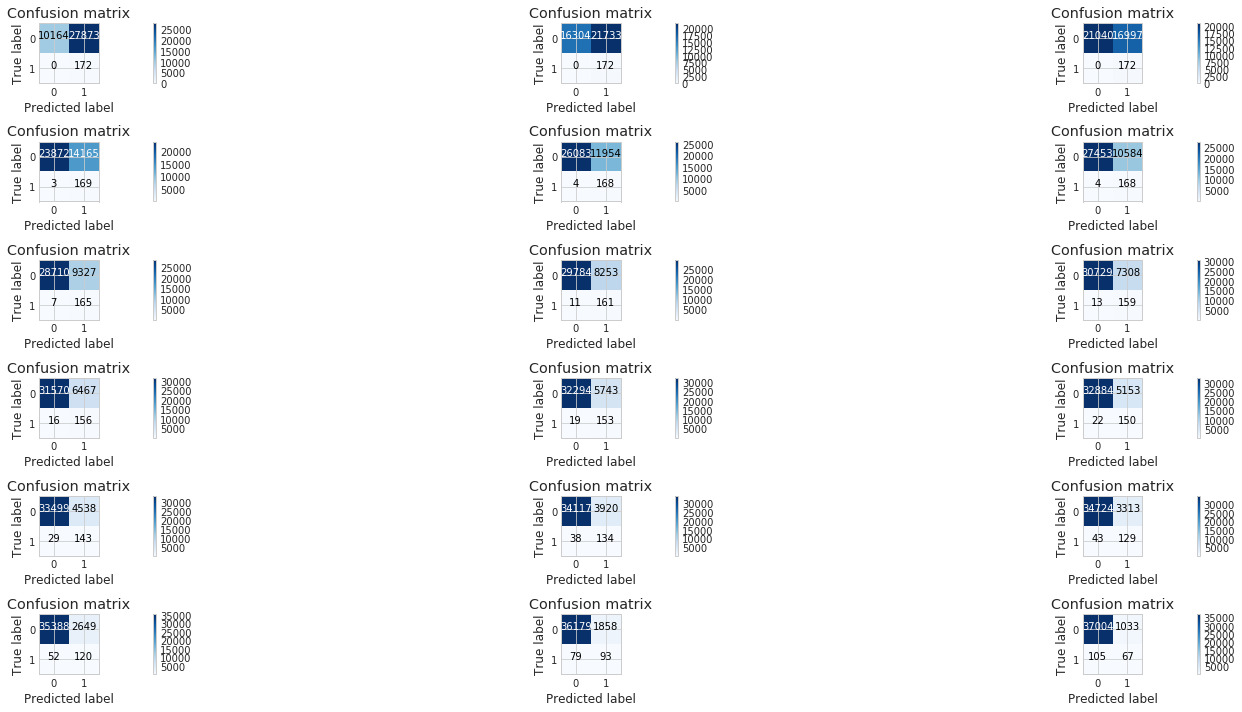

In [68]:
param_grid = {'loss': ["deviance", "exponential"],
              'learning_rate': [0.1, 0.01, 0.001],
             'criterion':["friedman_mse", "mse"],
             'warm_start':[False, True]}
gb_grid_search_rus = GridSearchCV(GradientBoostingClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = gb_grid_search_rus.fit(X_rus, y_rus)
y_pred = gb_grid_search_rus.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print("Best parameters: {}".format(gb_grid_search_rus.best_params_))
print("Best cross-validation score: {:.5f}".format(gb_grid_search_rus.best_score_))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=gb_grid_search_rus)

### ExtraTreesClassifier

#### cluster采样

Test set accuracy score: 0.66955
              precision    recall  f1-score   support

           0       0.67      1.00      0.80     25411
           1       1.00      0.01      0.03     12798

   micro avg       0.67      0.67      0.67     38209
   macro avg       0.83      0.51      0.41     38209
weighted avg       0.78      0.67      0.54     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'gini', 'n_estimators': 100, 'n_jobs': -1, 'warm_start': False}
Best cross-validation score: 0.78198
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall m

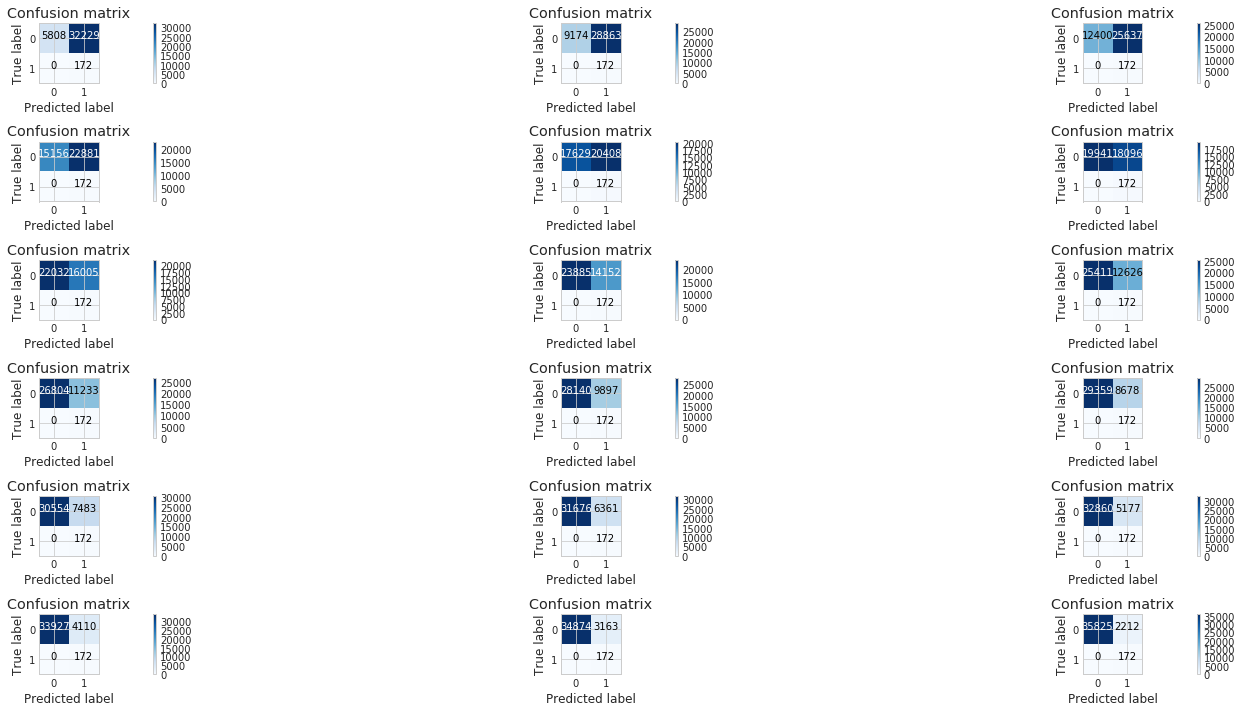

In [39]:
param_grid = {'n_estimators': [100],
              'criterion': ["gini"],
             'n_jobs':[-1],
             'warm_start':[False],
             "class_weight":[{0:1/38037, 1:1/172}]}
ext_grid_search = GridSearchCV(ExtraTreesClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = ext_grid_search.fit(X_clX_clusterer, y_cluster)
y_pred = ext_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(ext_grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(ext_grid_search.best_score_))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=ext_grid_search)

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0


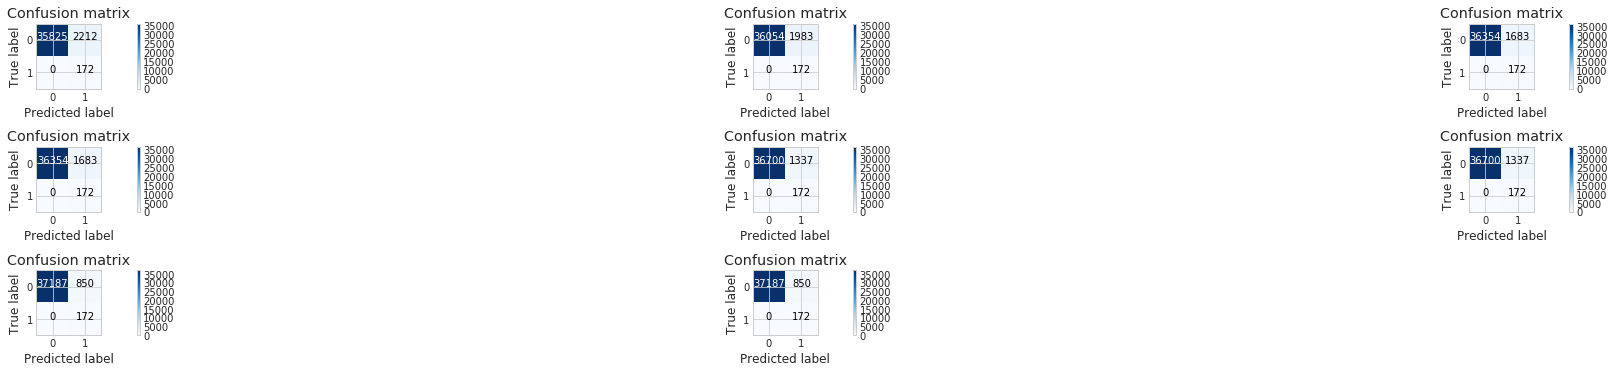

In [92]:
thresholds = [0.95, 0.96, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=ext_grid_search)

#### rus采样

Test set accuracy score: 0.79390
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     30162
           1       1.00      0.02      0.04      8047

   micro avg       0.79      0.79      0.79     38209
   macro avg       0.90      0.51      0.46     38209
weighted avg       0.84      0.79      0.71     38209

Best parameters: {'class_weight': {0: 2.6290191129689513e-05, 1: 0.005813953488372093}, 'criterion': 'gini', 'n_estimators': 100, 'n_jobs': -1, 'warm_start': False}
Best cross-validation score: 0.80523
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall m

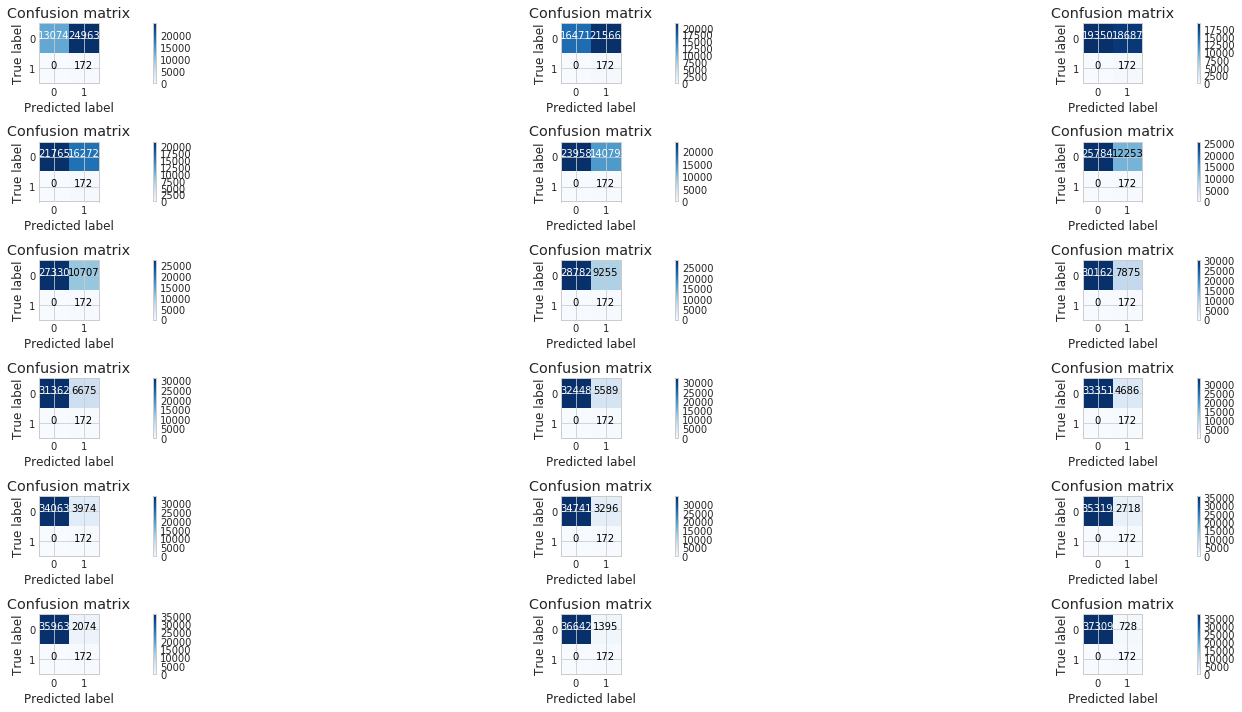

In [38]:
param_grid = {'loss': ["deviance", "exponential"],
              'learning_rate': [0.1, 0.01, 0.001],
             'criterion':["friedman_mse", "mse"],
             'warm_start':[False],
             "class_weight":[{0:1/38037, 1:1/172}]}
ext_grid_search_rus = GridSearchCV(ExtraTreesClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = ext_grid_search_rus.fit(X_rus, y_rus)
y_pred = ext_grid_search_rus.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(ext_grid_search_rus.best_params_))
print("Best cross-validation score: {:.5f}".format(ext_grid_search_rus.best_score_))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=ext_grid_search_rus)

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0


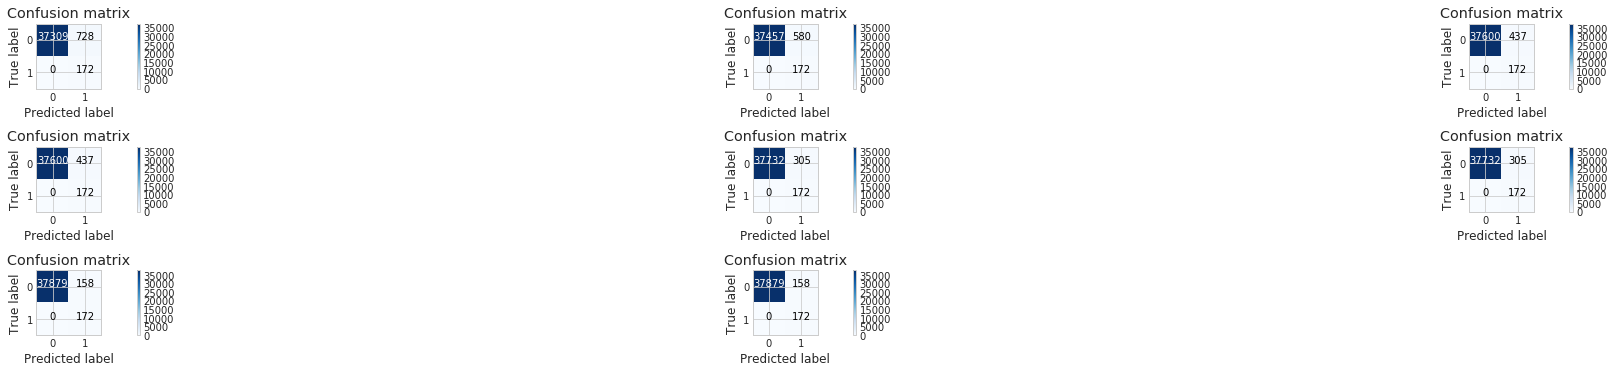

In [93]:
thresholds = [0.95, 0.96, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=ext_grid_search_rus)

#### nml采样

Test set accuracy score: 0.02070
              precision    recall  f1-score   support

           0       0.02      1.00      0.03       623
           1       0.99      0.00      0.01     37586

   micro avg       0.02      0.02      0.02     38209
   macro avg       0.50      0.50      0.02     38209
weighted avg       0.97      0.02      0.01     38209

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 10, 'n_jobs': -1, 'warm_start': True}
Best cross-validation score: 0.94477
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9941860465116279
Recall metric in the testing dataset:  0.9883720930232558
Recall metric in the testing datase

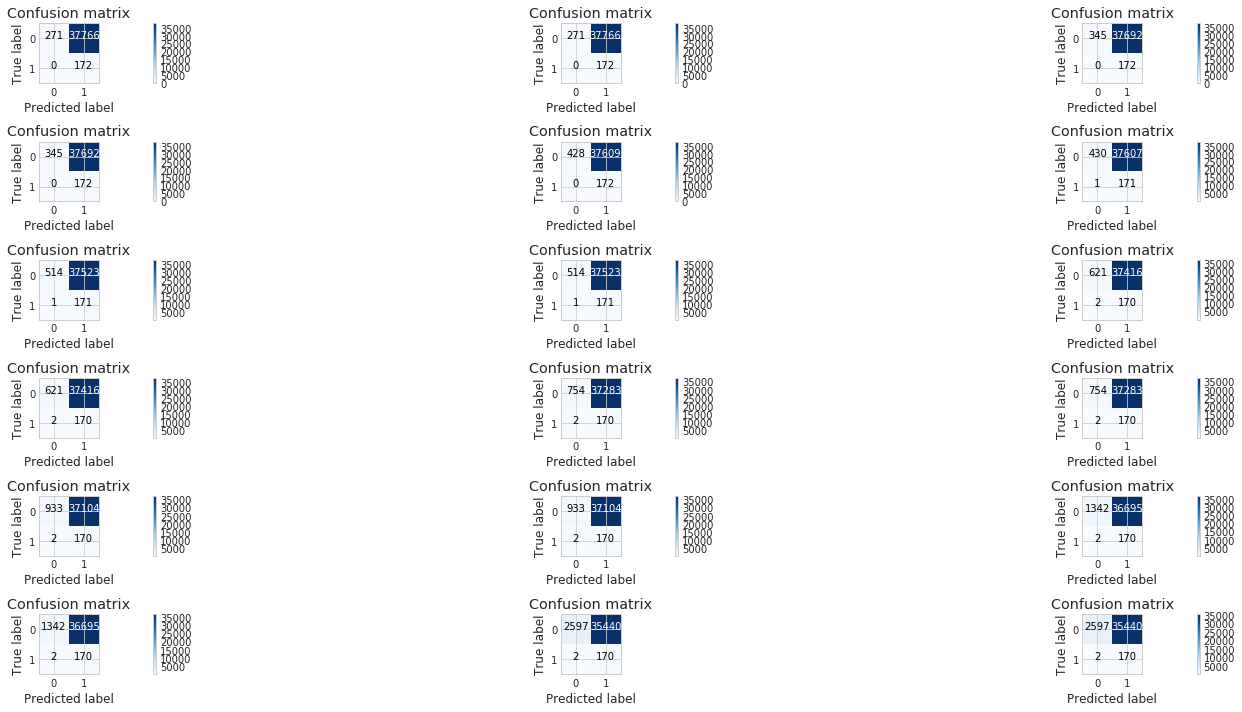

In [40]:
param_grid = {'n_estimators': [10,100,1000],
              'criterion': ["gini","entropy"],
             'n_jobs':[-1],
             'warm_start':[False,True],
             "class_weight":[{0:1/38037, 1:1/172},'balanced','balanced_subsample']}
ext_grid_search_nml = GridSearchCV(ExtraTreesClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = ext_grid_search_nml.fit(X_nml, y_nml)
y_pred = ext_grid_search_nml.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
print("Best parameters: {}".format(ext_grid_search_nml.best_params_))
print("Best cross-validation score: {:.5f}".format(ext_grid_search_nml.best_score_))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=ext_grid_search_nml)

### 模型集成

#### 4个模型集成

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9651162790697675
Recall metric in the testing dataset:  0.8313953488372093
Recall metric in the testing dataset:  0.5755813953488372


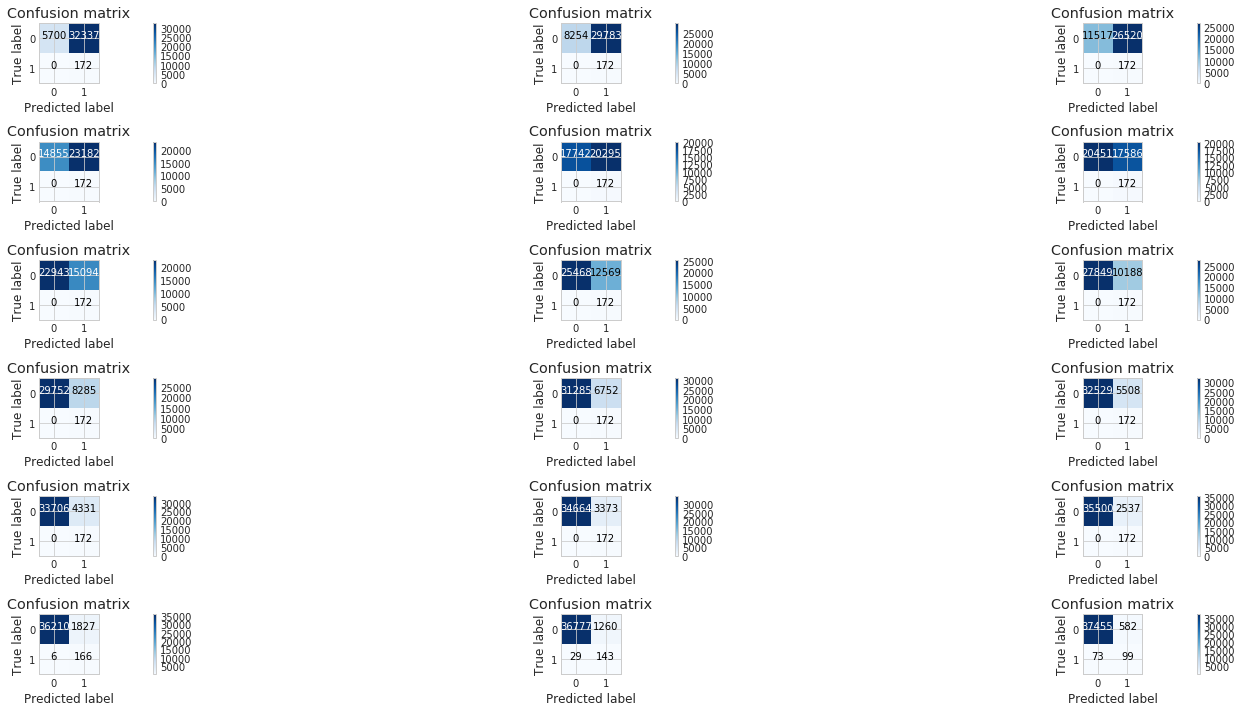

In [54]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, 
                         model_list=[random_grid_search, random_grid_search_rus,ext_grid_search_rus,ext_grid_search])

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9651162790697675
Recall metric in the testing dataset:  0.872093023255814
Recall metric in the testing dataset:  0.686046511627907
Recall metric in the testing dataset:  0.5174418604651163


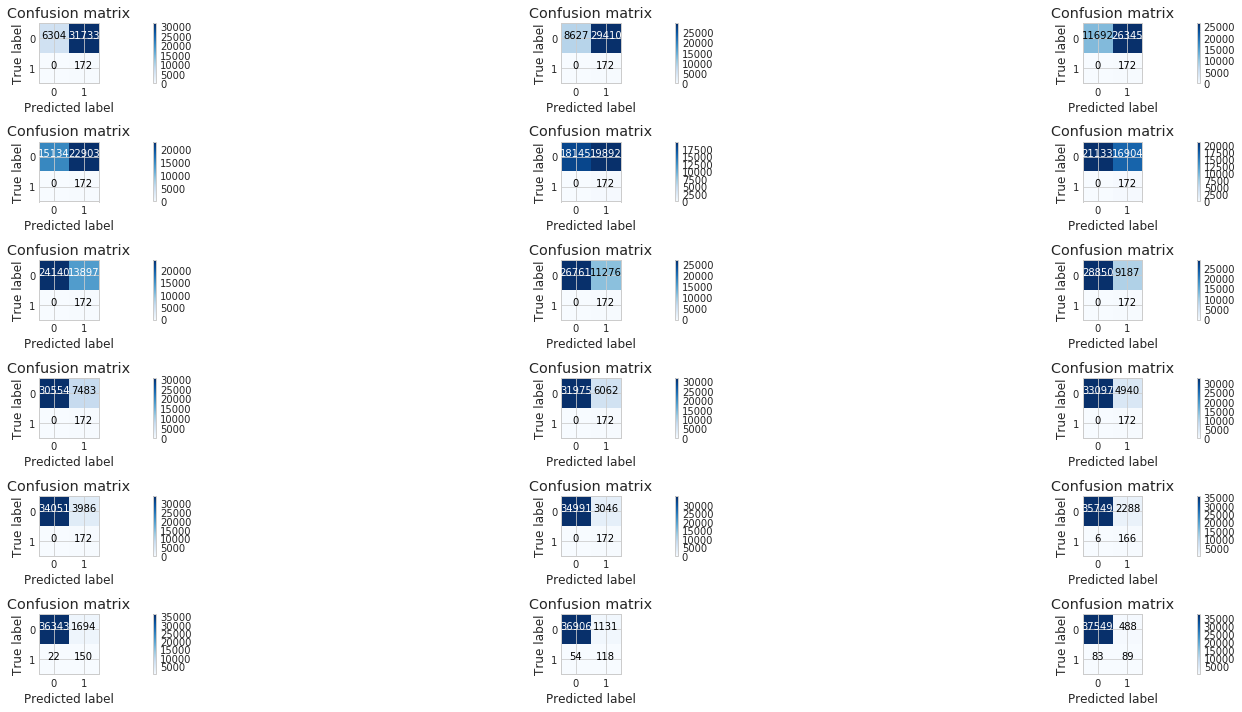

In [55]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, 
                         model_list=[random_grid_search, random_grid_search_rus,ext_grid_search_rus])

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9651162790697675
Recall metric in the testing dataset:  0.872093023255814
Recall metric in the testing dataset:  0.686046511627907
Recall metric in the testing dataset:  0.5174418604651163


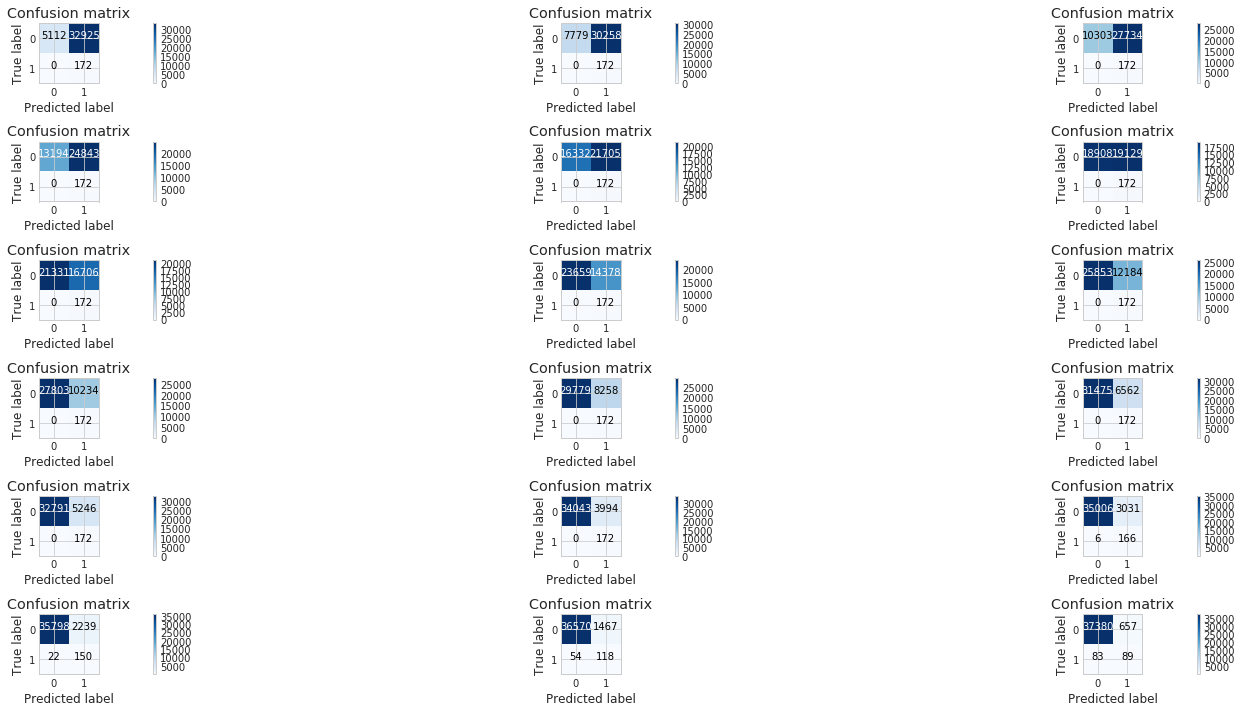

In [56]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, 
                         model_list=[random_grid_search, random_grid_search_rus,ext_grid_search])

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9011627906976745
Recall metric in the testing dataset:  0.75


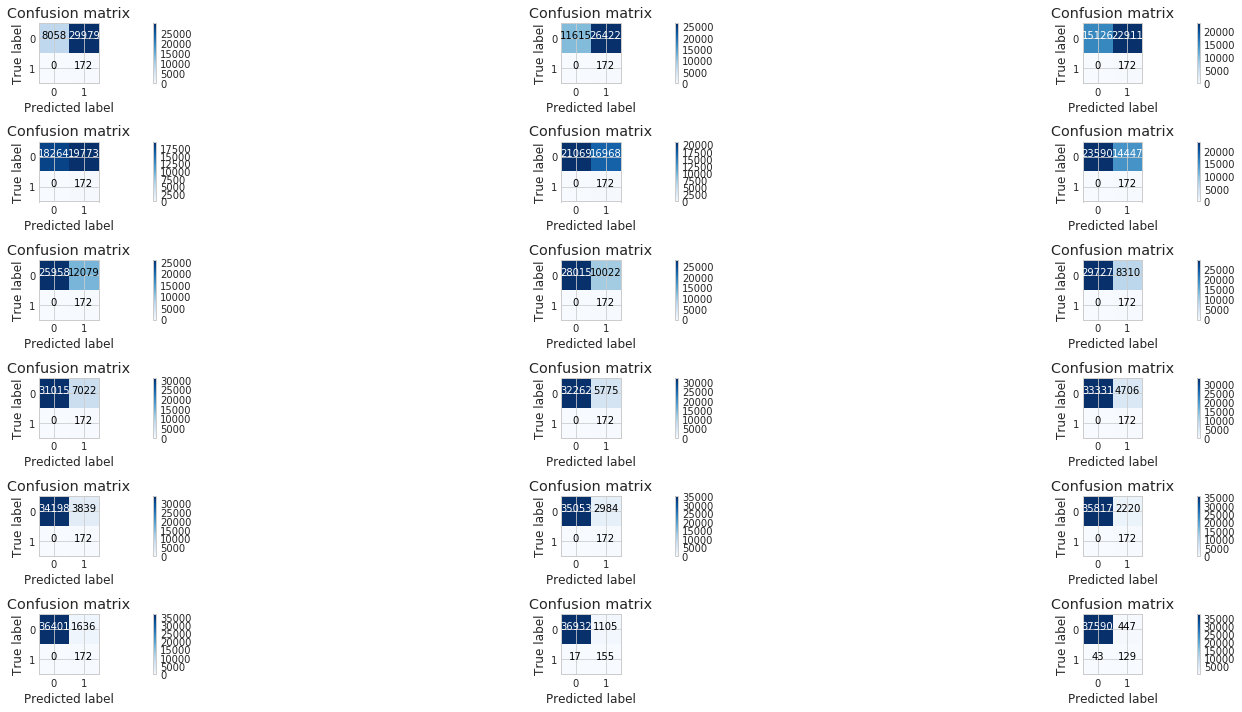

In [57]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, 
                         model_list=[random_grid_search_rus,ext_grid_search_rus,ext_grid_search])

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9418604651162791
Recall metric in the testing dataset:  0.7267441860465116


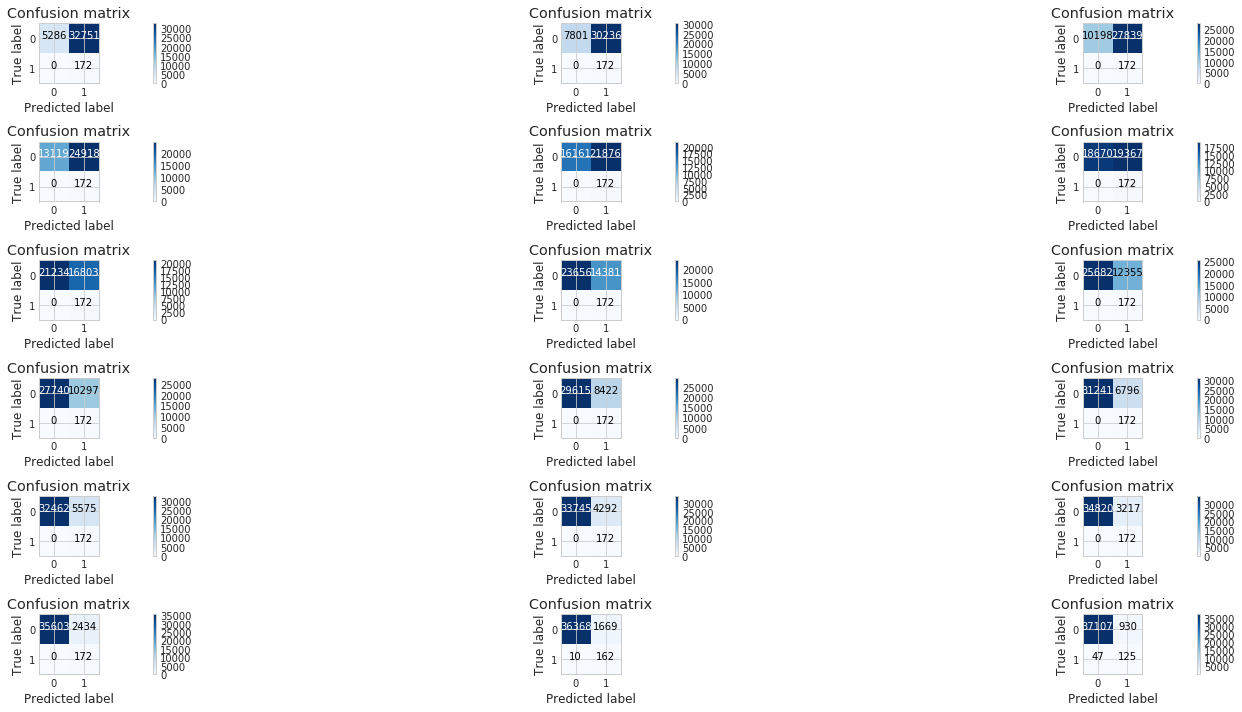

In [58]:
different_thrsholds_list(data_ml_df[col], data_ml_df['y_buy'], thresholds, 
                         model_list=[random_grid_search,ext_grid_search_rus,ext_grid_search])

In [70]:
joblib.dump(random_grid_search, './data/random_grid_search.m')
joblib.dump(random_grid_search_rus, './data/random_grid_search_rus.m')
joblib.dump(ext_grid_search_rus, './data/ext_grid_search_rus.m')
joblib.dump(ext_grid_search, './data/ext_grid_search.m')

['./data/ext_grid_search.m']

#### stacking技术

#### 使用cluster采样

In [82]:
x_stacking_1 = random_grid_search.predict_proba(X_cluster)
x_stacking_2 = random_grid_search_rus.predict_proba(X_cluster)
x_stacking_3 = ext_grid_search.predict_proba(X_cluster)
x_stacking_4 = ext_grid_search_rus.predict_proba(X_cluster)

In [84]:
x_stacking = np.concatenate([x_stacking_1, x_stacking_2, x_stacking_3, x_stacking_4], axis=-1)

Test set accuracy score: 0.72253
              precision    recall  f1-score   support

           0       0.72      1.00      0.84     27435
           1       1.00      0.02      0.03     10774

   micro avg       0.72      0.72      0.72     38209
   macro avg       0.86      0.51      0.43     38209
weighted avg       0.80      0.72      0.61     38209

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9069767441860465
Recall metric in the testing dataset:  0.1686046511627907
Recall m

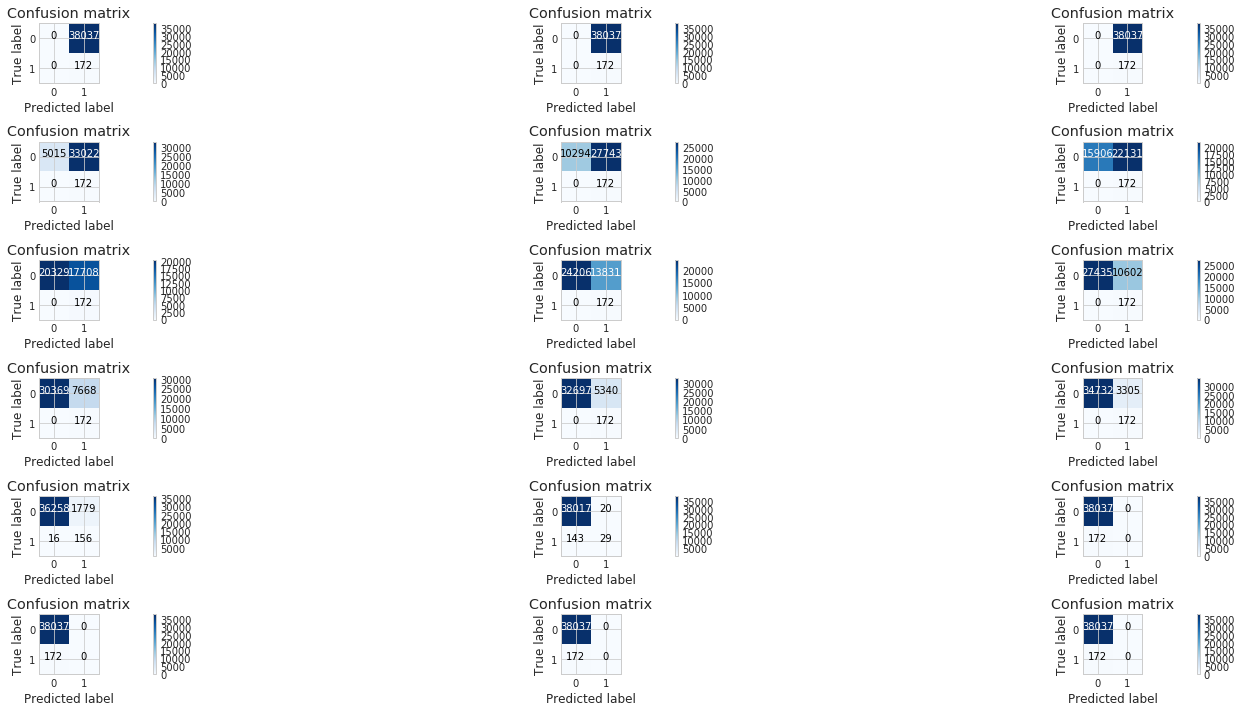

In [88]:
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

lg_grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = lg_grid_search.fit(x_stacking, y_cluster)
X_stacking = np.concatenate([random_grid_search.predict_proba(data_ml_df[col]),
                            random_grid_search_rus.predict_proba(data_ml_df[col]),
                            ext_grid_search.predict_proba(data_ml_df[col]),
                            ext_grid_search_rus.predict_proba(data_ml_df[col])], axis=-1)
y_pred = lg_grid_search.predict(X_stacking)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(X_stacking, data_ml_df['y_buy'], thresholds, model=lg_grid_search)

#### 使用rus采样

Test set accuracy score: 0.80905
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     30741
           1       1.00      0.02      0.05      7468

   micro avg       0.81      0.81      0.81     38209
   macro avg       0.90      0.51      0.47     38209
weighted avg       0.85      0.81      0.73     38209

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9186046511627907
Recall metric in the testing dataset:  0.22674418604651161
Recall 

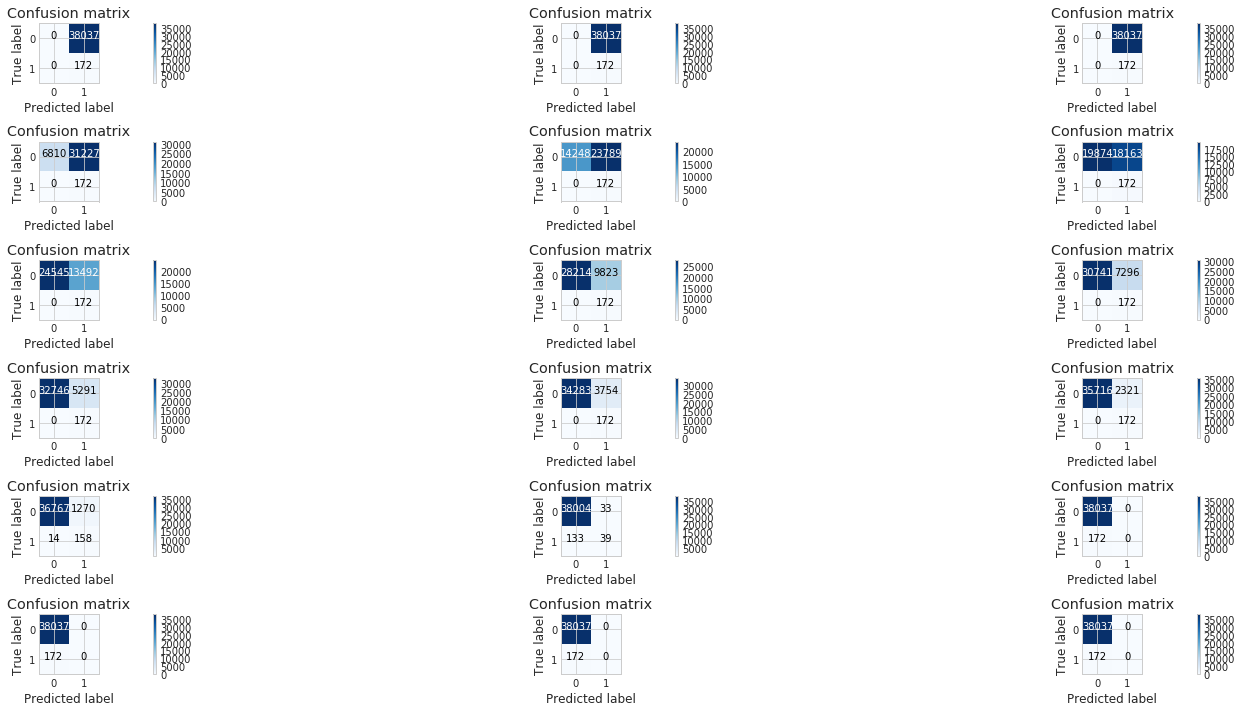

In [134]:
x_stacking_1 = random_grid_search.predict_proba(X_rus)
x_stacking_2 = random_grid_search_rus.predict_proba(X_rus)
x_stacking_3 = ext_grid_search.predict_proba(X_rus)
x_stacking_4 = ext_grid_search_rus.predict_proba(X_rus)
x_stacking = np.concatenate([x_stacking_1, x_stacking_2, x_stacking_3, x_stacking_4], axis=-1)
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

lg_grid_search_rus = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = lg_grid_search_rus.fit(x_stacking, y_rus)
X_stacking = np.concatenate([random_grid_search.predict_proba(data_ml_df[col]),
                            random_grid_search_rus.predict_proba(data_ml_df[col]),
                            ext_grid_search.predict_proba(data_ml_df[col]),
                            ext_grid_search_rus.predict_proba(data_ml_df[col])], axis=-1)
y_pred = lg_grid_search_rus.predict(X_stacking)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9, 0.95]
different_thrsholds(X_stacking, data_ml_df['y_buy'], thresholds, model=lg_grid_search_rus)
print("Best parameters: {}".format(lg_grid_search_rus.best_params_))
print("Best cross-validation score: {:.5f}".format(lg_grid_search_rus.best_score_))

#### 投票集成，效果极差

In [127]:
def vote_ensemble(X, y, thresholds=[0.7, 0.7, 0.8, 0.99, 0.99], model_list=[lg_grid_search_rus, lg_grid_search, random_grid_search_rus,ext_grid_search_rus,ext_grid_search]):
    model_num = len(model_list)
#     y_pred_proba = [0, 0]
#     for model in model_list:
#         y_pred_proba += model.predict_proba(X)  #predict_prob 获得一个概率值
#     y_pred_proba = y_pred_proba / model_num

    plt.figure()

    j = 1
    y_test_predictions_high_recall = np.reshape(np.array([0]*len(y)), (-1, 1))
    for model, i in zip(model_list, thresholds):
        print(i)
        if model == lg_grid_search or model == lg_grid_search_rus:
            X_stacking = np.concatenate([random_grid_search.predict_proba(X),
                            random_grid_search_rus.predict_proba(X),
                            ext_grid_search.predict_proba(X),
                            ext_grid_search_rus.predict_proba(X)], axis=-1)
            y_pred_proba = model.predict_proba(X_stacking)
        else:
            y_pred_proba = model.predict_proba(X)
#         print(y_test_predictions_high_recall.shape)
        tmp = y_pred_proba[:, 1] > i
#         print(tmp.shape)

        y_test_predictions_high_recall = np.concatenate([y_test_predictions_high_recall, np.reshape(tmp, (-1, 1))], axis=-1)
    half = len(y_test_predictions_high_recall[0]) // 2
    print(y_test_predictions_high_recall.shape)
    y_test = np.sum(y_test_predictions_high_recall, axis=-1)
    print(y_test.shape)
    y_test_predictions_high_recall = y_test > half
    print(y_test_predictions_high_recall.shape)

    plt.subplot(1,1,1)
#     j += 1

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names)

0.95
0.96
0.97
0.975
0.98
(38209, 6)
(38209,)
(38209,)
Recall metric in the testing dataset:  0.0


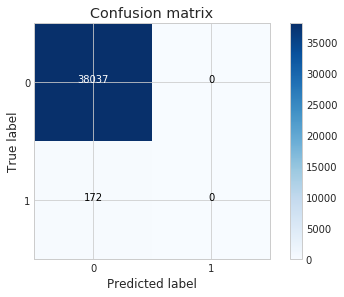

In [128]:
vote_ensemble(data_ml_df[col], data_ml_df['y_buy'], thresholds, model_list=[lg_grid_search_rus,lg_grid_search,random_grid_search_rus,ext_grid_search_rus,ext_grid_search])

In [129]:
def new_different_thresholds_list(X, y, thresholds, model_list=[lg_grid_search_rus, lg_grid_search, random_grid_search_rus,ext_grid_search_rus,ext_grid_search]):
    model_num = len(model_list)
    y_pred_proba = [0, 0]
    
    for model in model_list:
        if model == lg_grid_search or model == lg_grid_search_rus:
            X_stacking = np.concatenate([random_grid_search.predict_proba(X),
                            random_grid_search_rus.predict_proba(X),
                            ext_grid_search.predict_proba(X),
                            ext_grid_search_rus.predict_proba(X)], axis=-1)
            temp = model.predict_proba(X_stacking)
        else:
            temp = model.predict_proba(X)
        y_pred_proba += temp  #predict_prob 获得一个概率值
    y_pred_proba = y_pred_proba / model_num

    plt.figure(figsize=(30,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 

        plt.subplot(6,3,j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Plot non-normalized confusion matrix
        class_names = [0,1]
        plot_confusion_matrix(cnf_matrix
                              , classes=class_names)

### 模型预测

根据上面仿真结果，可以得到几个稍微较好的模型：  
1.由这四个模型random_grid_search, random_grid_search_rus,ext_grid_search_rus,ext_grid_search进行集成的模型，阈值设置为0.8，可以得到较好结果  
2.stacking技术进行模型集成。采用cluster和rus都可以获得较好结果，阈值设置为0.7

In [175]:
test_data_1 = pd.read_csv('data/ads_test.csv', index_col=0)
test_data = test_data_1[col]

In [176]:
test_data_ml_df = test_data
test_data_ml_df[col] = sc.transform(test_data_ml_df[col])
test_data_ml_df.head()

,isbuyer,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins
1,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,0.13737,0.13737,-0.07748,-0.61978,1.08823,0.29243
2,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,-1.11608,-1.11608,-0.07748,-0.61978,-1.33346,-0.55337
3,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,-0.42388,-0.42388,-0.07748,-0.61978,-0.71996,-0.47719
4,-0.21042,0.04398,-0.05120,1.34995,0.03645,-3.02083,1.05406,1.05406,-0.07748,1.61346,0.23257,-0.25097
5,-0.21042,0.04398,-0.05120,0.87278,0.03645,-3.08797,0.99794,0.99794,-0.07748,1.61346,1.23353,0.12995


#### 4模型集成预测

In [159]:
def model_predict(X, thresholds=0.8, model_list=[random_grid_search, random_grid_search_rus,ext_grid_search_rus,ext_grid_search]):
    model_num = len(model_list)
    y_pred_proba = [0, 0]
    for model in model_list:
        y_pred_proba += model.predict_proba(X)  #predict_prob 获得一个概率值
    y_pred_proba = y_pred_proba / model_num

    y_pred = y_pred_proba[:,1] > thresholds#预测出来的概率值是否大于阈值 
    return np.array(y_pred, dtype=np.int32), y_pred_proba[:, 0], y_pred_proba[:, 1]

In [160]:
y_pre_4_ensemble, y_proba_4_ensemble_for_0, y_proba_4_ensemble_for_1 = model_predict(test_data_ml_df[col], thresholds=0.9)

In [154]:
sum(y_pre_4_ensemble)

598

In [155]:
len(y_pre_4_ensemble)

16375

In [177]:
test_data_1['y_pre_4_ensemble'] = y_pre_4_ensemble
test_data_1['y_proba_4_ensemble_for_0'] = y_proba_4_ensemble_for_0
test_data_1['y_proba_4_ensemble_for_1'] = y_proba_4_ensemble_for_1

In [164]:
test_data_1.head()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_pre_4_ensemble,y_proba_4_ensemble_for_1,y_proba_4_ensemble_for_0
1,0,nan,1,0.00000,0.00000,0.00000,0.00000,72,72,0,0,154,1100,0,0.15925,0.84075
2,0,nan,1,0.00000,0.00000,0.00000,0.00000,5,5,0,0,4,12,0,0.67200,0.32800
3,0,nan,1,0.00000,0.00000,0.00000,0.00000,42,42,0,0,42,110,0,0.69575,0.30425
4,0,nan,2,0.00000,29.79167,0.00000,-106.18830,121,121,0,1,101,401,0,0.22925,0.77075
5,0,nan,2,0.00000,21.33333,0.00000,-108.32300,118,118,0,1,163,891,0,0.27600,0.72400


#### stacking技术和cluster采样

In [165]:
def stacking_predict(X, thresholds, model):
    X_stacking = np.concatenate([random_grid_search.predict_proba(test_data_ml_df[col]),
                    random_grid_search_rus.predict_proba(test_data_ml_df[col]),
                    ext_grid_search.predict_proba(test_data_ml_df[col]),
                    ext_grid_search_rus.predict_proba(test_data_ml_df[col])], axis=-1)
    y_pred_proba = model.predict_proba(X_stacking)
    y_pred = y_pred_proba[:,1] > thresholds#预测出来的概率值是否大于阈值 
    return np.array(y_pred, dtype=np.int32), y_pred_proba[:, 0], y_pred_proba[:, 1]    

In [172]:
stacking_cluster_pred, stacking_cluster_proba_for_0, stacking_cluster_proba_for_1 = stacking_predict(test_data_ml_df[col],
                                                                                                    thresholds=0.7, model=lg_grid_search)

In [171]:
sum(stacking_cluster_pred)

6

In [178]:
test_data_1['stacking_cluster_pred'] = stacking_cluster_pred
test_data_1['stacking_cluster_proba_for_0'] = stacking_cluster_proba_for_0
test_data_1['stacking_cluster_proba_for_1'] = stacking_cluster_proba_for_1

In [179]:
test_data_1.head()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_pre_4_ensemble,y_proba_4_ensemble_for_0,y_proba_4_ensemble_for_1,stacking_cluster_pred,stacking_cluster_proba_for_0,stacking_cluster_proba_for_1
1,0,nan,1,0.00000,0.00000,0.00000,0.00000,72,72,0,0,154,1100,0,0.84075,0.15925,0,0.72163,0.27837
2,0,nan,1,0.00000,0.00000,0.00000,0.00000,5,5,0,0,4,12,0,0.32800,0.67200,0,0.37593,0.62407
3,0,nan,1,0.00000,0.00000,0.00000,0.00000,42,42,0,0,42,110,0,0.30425,0.69575,0,0.35798,0.64202
4,0,nan,2,0.00000,29.79167,0.00000,-106.18830,121,121,0,1,101,401,0,0.77075,0.22925,0,0.69125,0.30875
5,0,nan,2,0.00000,21.33333,0.00000,-108.32300,118,118,0,1,163,891,0,0.72400,0.27600,0,0.66344,0.33656


#### stacking技术和rus采样

In [180]:
stacking_rus_pred, stacking_rus_proba_for_0, stacking_rus_proba_for_1 = stacking_predict(test_data_ml_df[col],
                                                                                                    thresholds=0.7, model=lg_grid_search_rus)
test_data_1['stacking_rus_pred'] = stacking_rus_pred
test_data_1['stacking_rus_proba_for_0'] = stacking_rus_proba_for_0
test_data_1['stacking_rus_proba_for_1'] = stacking_rus_proba_for_1

In [181]:
test_data_1.head()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,...,num_checkins,y_pre_4_ensemble,y_proba_4_ensemble_for_0,y_proba_4_ensemble_for_1,stacking_cluster_pred,stacking_cluster_proba_for_0,stacking_cluster_proba_for_1,stacking_rus_pred,stacking_rus_proba_for_0,stacking_rus_proba_for_1
1,0,nan,1,0.00000,0.00000,0.00000,0.00000,72,72,0,...,1100,0,0.84075,0.15925,0,0.72163,0.27837,0,0.71179,0.28821
2,0,nan,1,0.00000,0.00000,0.00000,0.00000,5,5,0,...,12,0,0.32800,0.67200,0,0.37593,0.62407,0,0.46601,0.53399
3,0,nan,1,0.00000,0.00000,0.00000,0.00000,42,42,0,...,110,0,0.30425,0.69575,0,0.35798,0.64202,0,0.44725,0.55275
4,0,nan,2,0.00000,29.79167,0.00000,-106.18830,121,121,0,...,401,0,0.77075,0.22925,0,0.69125,0.30875,0,0.67852,0.32148
5,0,nan,2,0.00000,21.33333,0.00000,-108.32300,118,118,0,...,891,0,0.72400,0.27600,0,0.66344,0.33656,0,0.65548,0.34452


In [182]:
sum(stacking_rus_pred)

596

In [183]:
test_data_1.to_csv('data/ads_result.csv', index = False)